# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

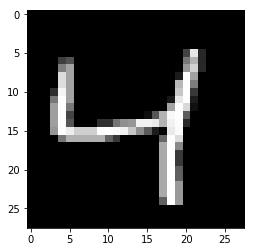

In [7]:
img = mnist.train.images[2]
plt.imshow(img.reshape(28,28), cmap="gray")

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [13]:
mnist.train.images[2].shape

(784,)

In [11]:
mnist.train.images.shape

(60000, 784)

In [73]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 64 # feel free to change this value

image_size = mnist.train.images.shape[1]

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, image_size))
targets_ = tf.placeholder(tf.float32, (None, image_size))

# Output of hidden layer, single fully connected layer here with ReLU activation
encoded = tf.layers.dense(inputs=inputs_, units=encoding_dim, activation=tf.nn.relu)

# Output layer logits, fully connected layer with no activation
logits = tf.layers.dense(encoded, image_size)
# Sigmoid output from logits
decoded = tf.nn.sigmoid(logits)

# Sigmoid cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
# Mean of the loss
cost = tf.reduce_mean(loss)

# Adam optimizer
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [74]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [75]:
sess.run(tf.global_variables_initializer())
epochs = 20
batch_size=128
num_features = image_size = mnist.train.images.shape[0]
for i in range(epochs):
    for batch_num in range(num_features//batch_size):
        batch = mnist.train.next_batch(batch_size)
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_:batch[0], targets_:batch[0]})
    print("epoch: {} \nTrain loss: {}".format(i, batch_cost))

epoch: 0 
Train loss: 0.13366197049617767
epoch: 1 
Train loss: 0.10193222761154175
epoch: 2 
Train loss: 0.09032369405031204
epoch: 3 
Train loss: 0.07859146595001221
epoch: 4 
Train loss: 0.07704804092645645
epoch: 5 
Train loss: 0.07657833397388458
epoch: 6 
Train loss: 0.07530944049358368
epoch: 7 
Train loss: 0.07750851660966873
epoch: 8 
Train loss: 0.07357993721961975
epoch: 9 
Train loss: 0.07585073262453079
epoch: 10 
Train loss: 0.07440893352031708
epoch: 11 
Train loss: 0.07748517394065857
epoch: 12 
Train loss: 0.07306136190891266
epoch: 13 
Train loss: 0.06939885020256042
epoch: 14 
Train loss: 0.07527998834848404
epoch: 15 
Train loss: 0.0717218816280365
epoch: 16 
Train loss: 0.0748615637421608
epoch: 17 
Train loss: 0.0705542340874672
epoch: 18 
Train loss: 0.07092160731554031
epoch: 19 
Train loss: 0.07376310974359512


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

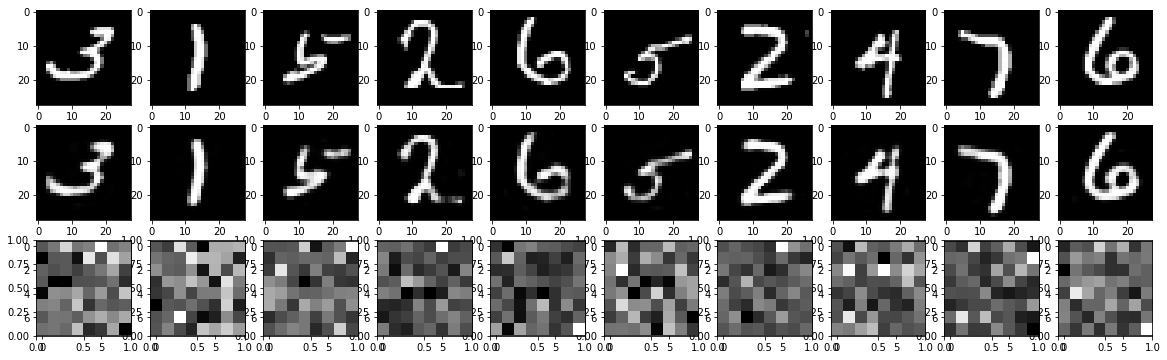

In [85]:
imgs_10 = mnist.train.images[:10]
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20,6))
compressed, reconstructed = sess.run([encoded, decoded], feed_dict={inputs_:imgs_10})


# axes
for images,row in zip([imgs_10, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(28,28), cmap="gray")
        

# for images,comp_images,row in zip([imgs_10, reconstructed], compressed, axes):
#     for img, comp, ax in zip(images, comp_images, row):
#         ax.imshow(img.reshape(28,28), cmap="gray")
#         ax.imshow(comp.reshape(8,8), cmap='gray')
        

for i in range(10):
    ax = fig.add_subplot(3,10, 20+i+1)
    ax.imshow(compressed[i].reshape(8,8), cmap='gray')

In [86]:
sess.close()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.